In [5]:
import torch
from transformers import PreTrainedModel, AutoTokenizer
from typing import List, Dict, Set, Tuple, Optional
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from llm_unlearning.unlearning_datasets.tofu import TofuDataset
from llm_unlearning.evals.utils import extract_question_tokens, extract_answer_tokens
from llm_unlearning.models.models import load_model_and_tokenizer
from omegaconf import OmegaConf
from collections import defaultdict

def load_models_and_tokenizer(target_path: str, reference_path: str) -> Tuple[PreTrainedModel, PreTrainedModel, AutoTokenizer]:
    config_target = OmegaConf.create({"path": target_path, "tokenizer_path": "microsoft/phi-1_5", "fp16": True})
    target_model, tokenizer = load_model_and_tokenizer(config_target)
    target_model = target_model.to('cuda' if torch.cuda.is_available() else 'cpu')

    config_reference = OmegaConf.create({"path": reference_path, "tokenizer_path": "microsoft/phi-1_5", "fp16": True})
    reference_model, _ = load_model_and_tokenizer(config_reference)
    reference_model = reference_model.to('cuda' if torch.cuda.is_available() else 'cpu')

    return target_model, reference_model, tokenizer

def load_tofu_dataset(tokenizer: AutoTokenizer) -> TofuDataset:
    config = OmegaConf.create({
        "split": "full",
        "max_length": 512,
        "question_key": "question",
        "answer_key": "answer",
        "question_start_tag": "Question: ",
        "question_end_tag": "\nAnswer: ",
        "answer_tag": ""
    })
    return TofuDataset(tokenizer, config)

def identify_copy_tokens(question_ids: torch.Tensor, answer_ids: torch.Tensor, pad_token_id: int) -> Set[int]:
    question_tokens = {t.item() for t in question_ids[0] if t.item() != pad_token_id}
    answer_tokens = {t.item() for t in answer_ids[0] if t.item() != pad_token_id}
    return question_tokens.intersection(answer_tokens)

def compute_token_probabilities(model: PreTrainedModel, input_ids: torch.Tensor,
                              attention_mask: torch.Tensor) -> Dict[int, List[float]]:
    device = next(model.parameters()).device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    log_probs = torch.log_softmax(logits, dim=-1)
    token_log_probs = {}
    for pos in range(input_ids.shape[1] - 1):
        next_token = input_ids[0, pos + 1].item()
        token_log_probs[pos] = log_probs[0, pos, next_token].item()

    return token_log_probs

def compute_delta_statistics(dataset: TofuDataset,
                           retain_model: PreTrainedModel,
                           npo_model: PreTrainedModel,
                           tokenizer: AutoTokenizer,
                           num_samples: int = None,
                           take_from_back: bool = False) -> Tuple[List[float], List[float]]:
    copy_deltas = []
    non_copy_deltas = []
    samples = range(len(dataset)) if num_samples is None else range(min(num_samples, len(dataset)))

    for idx in tqdm(samples, desc="Computing deltas"):
        sample = dataset[idx] if not take_from_back else dataset[-idx]
        for key in sample:
            if isinstance(sample[key], torch.Tensor):
                sample[key] = sample[key].unsqueeze(0)

        question_ids, _ = extract_question_tokens(sample, tokenizer.pad_token_id)
        answer_ids = extract_answer_tokens(sample["input_ids"],
                                         sample["question_length"],
                                         tokenizer.pad_token_id)

        copy_token_ids = identify_copy_tokens(question_ids, answer_ids, tokenizer.pad_token_id)
        retain_probs = compute_token_probabilities(retain_model, sample["input_ids"], sample["attention_mask"])
        npo_probs = compute_token_probabilities(npo_model, sample["input_ids"], sample["attention_mask"])

        question_length = sample["question_length"].item()
        for pos in retain_probs.keys():
            if pos >= question_length:
                next_token = sample["input_ids"][0, pos + 1].item()
                delta = retain_probs[pos] - npo_probs[pos]

                if next_token in copy_token_ids:
                    copy_deltas.append(delta)
                else:
                    non_copy_deltas.append(delta)

    return copy_deltas, non_copy_deltas

def analyze_deltas(copy_deltas: List[float], non_copy_deltas: List[float]) -> Dict:
    return {
        "copy_tokens": {
            "mean": np.mean(copy_deltas),
            "std": np.std(copy_deltas),
            "median": np.median(copy_deltas),
            "min": np.min(copy_deltas),
            "max": np.max(copy_deltas),
            "count": len(copy_deltas)
        },
        "non_copy_tokens": {
            "mean": np.mean(non_copy_deltas),
            "std": np.std(non_copy_deltas),
            "median": np.median(non_copy_deltas),
            "min": np.min(non_copy_deltas),
            "max": np.max(non_copy_deltas),
            "count": len(non_copy_deltas)
        }
    }

In [3]:
target_path = "/nfs/homedirs/gudm/development/new/results/baseline/20240908_150146_npo_forget10_7/checkpoint-120"
reference_path = "/nfs/homedirs/gudm/development/new/results/finetune/retain90_10e/checkpoint-1120"
target_model, retain_model, tokenizer = load_models_and_tokenizer(target_path, reference_path)
dataset = load_tofu_dataset(tokenizer)

Loading model from local checkpoint: /nfs/homedirs/gudm/development/new/results/baseline/20240908_150146_npo_forget10_7/checkpoint-120


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5
Loading model from local checkpoint: /nfs/homedirs/gudm/development/new/results/finetune/retain90_10e/checkpoint-1120


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5


Loading model from local checkpoint: /nfs/homedirs/gudm/development/new/results/baseline/20240908_150146_npo_forget10_7/checkpoint-120


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5
Loading model from local checkpoint: /nfs/homedirs/gudm/development/new/results/finetune/retain90_10e/checkpoint-1120


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5


Computing deltas: 100%|██████████| 100/100 [00:07<00:00, 14.19it/s]


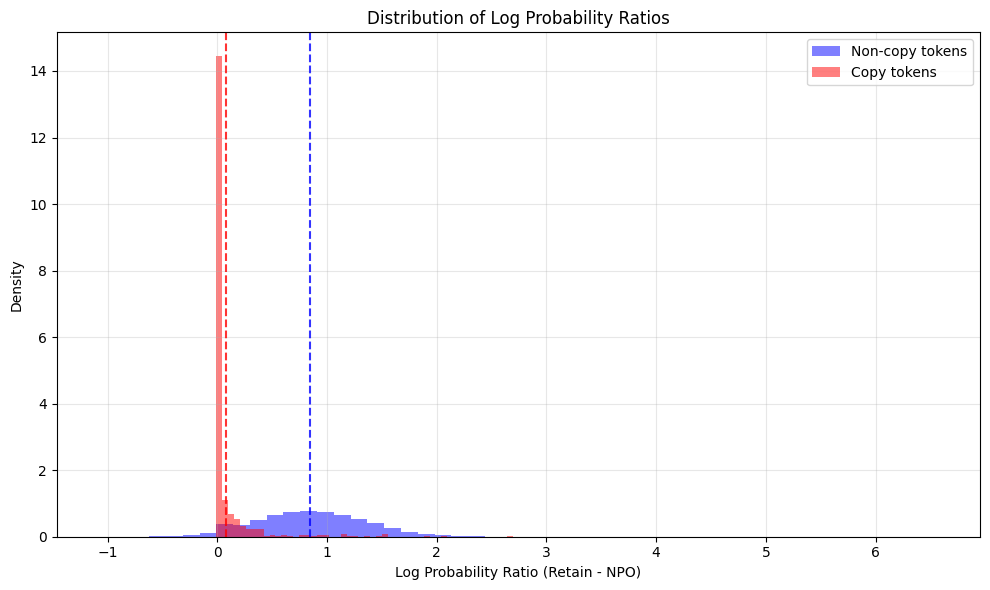

In [ ]:
def plot_delta_distributions(copy_deltas, non_copy_deltas, bins=50):
    plt.figure(figsize=(10, 6))

    plt.hist(non_copy_deltas, bins=bins, alpha=0.5, label='Non-copy tokens',
             density=True, color='blue')
    plt.hist(copy_deltas, bins=bins, alpha=0.5, label='Copy tokens',
             density=True, color='red')

    plt.xlabel('Log Probability Ratio (Retain - NPO)')
    plt.ylabel('Density')
    plt.title('Distribution of Log Probability Ratios')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add mean lines
    plt.axvline(np.mean(copy_deltas), color='red', linestyle='--', alpha=0.8)
    plt.axvline(np.mean(non_copy_deltas), color='blue', linestyle='--', alpha=0.8)

    plt.tight_layout()
    return plt.gcf()

copy_deltas, non_copy_deltas = compute_delta_statistics(
    dataset=dataset,
    retain_model=retain_model,
    npo_model=target_model,
    tokenizer=tokenizer,
    num_samples=100,
    take_from_back=True
)

fig = plot_delta_distributions(copy_deltas, non_copy_deltas)
plt.show()

In [ ]:
copy_deltas, non_copy_deltas = compute_delta_statistics(
    dataset=dataset,
    retain_model=retain_model,
    npo_model=target_model,
    tokenizer=tokenizer,
    num_samples=400,
    take_from_back=True
)

fig = plot_delta_distributions(copy_deltas, non_copy_deltas)
plt.show()

Computing deltas: 100%|██████████| 400/400 [00:28<00:00, 13.82it/s]


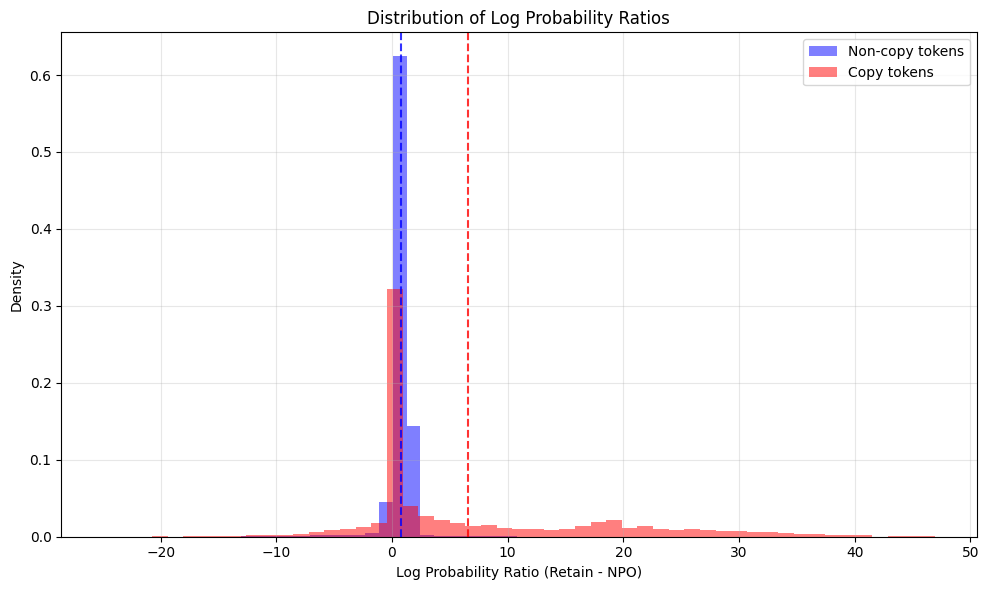

In [ ]:
def get_forgotten_tokens(dataset: TofuDataset, tokenizer: AutoTokenizer, num_forget: int = 400) -> Set[int]:
    forgotten_tokens = set()
    for idx in range(num_forget):
        sample = dataset[-idx-1]
        sample = {k: v.unsqueeze(0) if isinstance(v, torch.Tensor) else v for k, v in sample.items()}

        _, _ = extract_question_tokens(sample, tokenizer.pad_token_id)
        answer_ids = extract_answer_tokens(sample["input_ids"],
                                         sample["question_length"],
                                         tokenizer.pad_token_id)

        forgotten_tokens.update(t.item() for t in answer_ids[0] if t.item() != tokenizer.pad_token_id)

    return forgotten_tokens

def analyze_retain_probabilities(dataset: TofuDataset,
                               retain_model: PreTrainedModel,
                               npo_model: PreTrainedModel,
                               tokenizer: AutoTokenizer,
                               num_retain: int = 3600) -> Tuple[List[float], List[float]]:

    forgotten_tokens = get_forgotten_tokens(dataset, tokenizer)
    print(f"Found {len(forgotten_tokens)} unique tokens in forget samples")

    affected_deltas = []
    unaffected_deltas = []

    for idx in tqdm(range(num_retain), desc="Analyzing retain samples"):
        sample = dataset[idx]
        sample = {k: v.unsqueeze(0) if isinstance(v, torch.Tensor) else v for k, v in sample.items()}

        retain_probs = compute_token_probabilities(retain_model, sample["input_ids"], sample["attention_mask"])
        npo_probs = compute_token_probabilities(npo_model, sample["input_ids"], sample["attention_mask"])

        question_length = sample["question_length"].item()
        for pos in retain_probs.keys():
            if pos >= question_length:
                next_token = sample["input_ids"][0, pos + 1].item()
                delta = retain_probs[pos] - npo_probs[pos]

                if next_token in forgotten_tokens:
                    affected_deltas.append(delta)
                else:
                    unaffected_deltas.append(delta)

    return affected_deltas, unaffected_deltas

def plot_cross_sample_effect(affected_deltas, unaffected_deltas, bins=50):
    plt.figure(figsize=(10, 6))

    plt.hist(unaffected_deltas, bins=bins, alpha=0.5,
             label='Tokens not in forget samples', density=True, color='blue')
    plt.hist(affected_deltas, bins=bins, alpha=0.5,
             label='Tokens also in forget samples', density=True, color='red')

    plt.xlabel('Log Probability Ratio (Retain - NPO)')
    plt.ylabel('Density')
    plt.title('Cross-Sample Effect of Unlearning')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.axvline(np.mean(affected_deltas), color='red', linestyle='--', alpha=0.8,
                label=f'Mean (affected): {np.mean(affected_deltas):.3f}')
    plt.axvline(np.mean(unaffected_deltas), color='blue', linestyle='--', alpha=0.8,
                label=f'Mean (unaffected): {np.mean(unaffected_deltas):.3f}')

    plt.tight_layout()
    return plt.gcf()

Found 2572 unique tokens in forget samples


Analyzing retain samples: 100%|██████████| 1000/1000 [01:13<00:00, 13.59it/s]


Statistics: {'copy_tokens': {'mean': np.float64(0.28771415166486847), 'std': np.float64(0.6548966237122638), 'median': np.float64(0.04813696816563606), 'min': np.float64(-0.06398109346628189), 'max': np.float64(12.308599312324077), 'count': 23827}, 'non_copy_tokens': {'mean': np.float64(0.7892073959240831), 'std': np.float64(0.45132549072840084), 'median': np.float64(0.782264232635498), 'min': np.float64(-1.542494773864746), 'max': np.float64(8.825931889936328), 'count': 467294}}


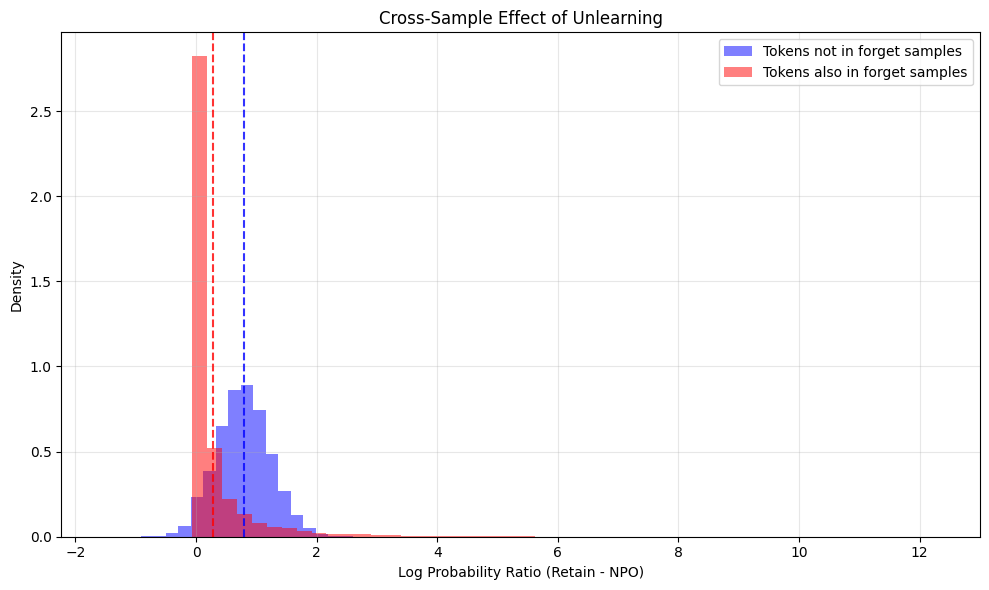

In [27]:
affected_deltas, unaffected_deltas = analyze_retain_probabilities(
    dataset=dataset,
    retain_model=retain_model,
    npo_model=target_model,
    tokenizer=tokenizer,
    num_retain=1000,
)

stats = analyze_deltas(affected_deltas, unaffected_deltas)
print("Statistics:", stats)

fig = plot_cross_sample_effect(affected_deltas, unaffected_deltas)
plt.show()

Analyzing copy attention patterns: 100%|██████████| 400/400 [00:24<00:00, 16.63it/s]


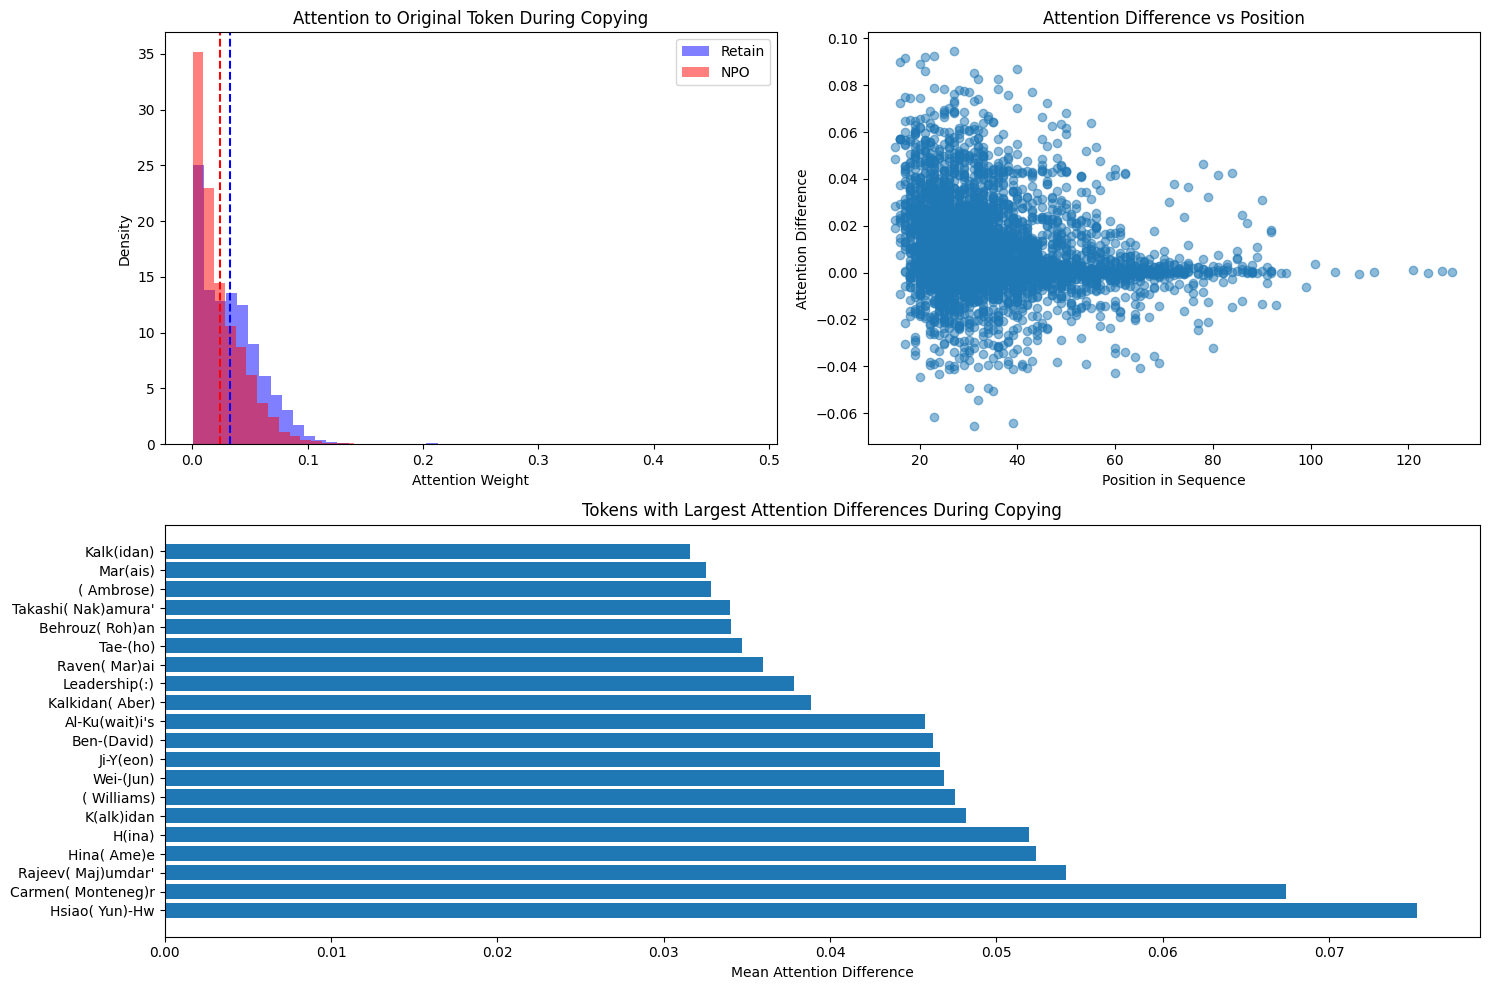

In [ ]:
def get_attention_patterns(model: PreTrainedModel,
                         input_ids: torch.Tensor,
                         attention_mask: torch.Tensor) -> torch.Tensor:
    device = next(model.parameters()).device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True)

    attention_patterns = torch.stack(outputs.attentions, dim=0)
    return attention_patterns

def analyze_attention_for_token(attention_patterns: torch.Tensor,
                              token_position: int,
                              layer_idx: Optional[int] = None) -> Tuple[torch.Tensor, torch.Tensor]:
    if layer_idx is not None:
        patterns = attention_patterns[layer_idx:layer_idx+1]
    else:
        patterns = attention_patterns

    avg_pattern = patterns.mean(dim=(0,1))[0]  # Average over layers and heads
    attention_given = avg_pattern[token_position, :]
    attention_received = avg_pattern[:, token_position]

    return attention_given, attention_received

def analyze_copy_attention(dataset: TofuDataset,
                         retain_model: PreTrainedModel,
                         npo_model: PreTrainedModel,
                         tokenizer: AutoTokenizer,
                         num_samples: int = 400,
                         take_from_back: bool = True) -> Dict:
    attention_stats = {
        "retain": defaultdict(list),
        "npo": defaultdict(list),
        "token_info": []
    }

    samples = range(len(dataset)-num_samples, len(dataset)) if take_from_back else range(num_samples)

    for idx in tqdm(samples, desc="Analyzing copy attention patterns"):
        sample = dataset[idx]
        for key in sample:
            if isinstance(sample[key], torch.Tensor):
                sample[key] = sample[key].unsqueeze(0)

        question_ids, _ = extract_question_tokens(sample, tokenizer.pad_token_id)
        question_length = sample["question_length"].item()

        question_tokens = [(pos, t.item()) for pos, t in enumerate(question_ids[0])
                          if t.item() != tokenizer.pad_token_id]
        question_token_dict = defaultdict(list)
        for pos, token in question_tokens:
            question_token_dict[token].append(pos)

        retain_attention = get_attention_patterns(retain_model, sample["input_ids"], sample["attention_mask"])
        npo_attention = get_attention_patterns(npo_model, sample["input_ids"], sample["attention_mask"])

        # For each position in answer, check if it's a copy token
        seq_len = sample["input_ids"].shape[1]
        for ans_pos in range(question_length, seq_len-1):
            if ans_pos >= seq_len-1: continue

            token = sample["input_ids"][0, ans_pos+1].item()  # +1 because we want the token being predicted
            if token in question_token_dict:
                orig_positions = question_token_dict[token]
                token_str = tokenizer.decode([token])

                retain_given, _ = analyze_attention_for_token(retain_attention, ans_pos)
                npo_given, _ = analyze_attention_for_token(npo_attention, ans_pos)

                retain_to_orig = sum(retain_given[p].item() for p in orig_positions)
                npo_to_orig = sum(npo_given[p].item() for p in orig_positions)

                attention_stats["retain"]["to_orig"].append(retain_to_orig)
                attention_stats["npo"]["to_orig"].append(npo_to_orig)
                attention_stats["retain"]["full_pattern"].append(retain_given.cpu().numpy())
                attention_stats["npo"]["full_pattern"].append(npo_given.cpu().numpy())
                attention_stats["token_info"].append({
                    "token": token_str,
                    "ans_pos": ans_pos,
                    "orig_pos": orig_positions,
                    "sample_idx": idx
                })

    return attention_stats

def plot_copy_attention_analysis(attention_stats: Dict):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    retain_attn = attention_stats["retain"]["to_orig"]
    npo_attn = attention_stats["npo"]["to_orig"]

    plt.hist(retain_attn, bins=50, alpha=0.5, label='Retain', color='blue', density=True)
    plt.hist(npo_attn, bins=50, alpha=0.5, label='NPO', color='red', density=True)
    plt.axvline(np.mean(retain_attn), color='blue', linestyle='--')
    plt.axvline(np.mean(npo_attn), color='red', linestyle='--')
    plt.title("Attention to Original Token During Copying")
    plt.xlabel("Attention Weight")
    plt.ylabel("Density")
    plt.legend()

    plt.subplot(2, 2, 2)
    positions = [info["ans_pos"] for info in attention_stats["token_info"]]
    differences = [r - n for r, n in zip(retain_attn, npo_attn)]

    plt.scatter(positions, differences, alpha=0.5)
    plt.title("Attention Difference vs Position")
    plt.xlabel("Position in Sequence")
    plt.ylabel("Retain - NPO Attention")

def analyze_copy_attention(dataset: TofuDataset,
                         retain_model: PreTrainedModel,
                         npo_model: PreTrainedModel,
                         tokenizer: AutoTokenizer,
                         num_samples: int = 400,
                         take_from_back: bool = True,
                         use_ratio: bool = False) -> Dict:
    attention_stats = {
        "retain": defaultdict(list),
        "npo": defaultdict(list),
        "token_info": [],
        "use_ratio": use_ratio
    }

    samples = range(len(dataset)-num_samples, len(dataset)) if take_from_back else range(num_samples)

    for idx in tqdm(samples, desc="Analyzing copy attention patterns"):
        sample = dataset[idx]
        for key in sample:
            if isinstance(sample[key], torch.Tensor):
                sample[key] = sample[key].unsqueeze(0)

        question_ids, _ = extract_question_tokens(sample, tokenizer.pad_token_id)
        question_length = sample["question_length"].item()

        question_tokens = [(pos, t.item()) for pos, t in enumerate(question_ids[0])
                          if t.item() != tokenizer.pad_token_id]
        question_token_dict = defaultdict(list)
        for pos, token in question_tokens:
            question_token_dict[token].append(pos)

        retain_attention = get_attention_patterns(retain_model, sample["input_ids"], sample["attention_mask"])
        npo_attention = get_attention_patterns(npo_model, sample["input_ids"], sample["attention_mask"])

        seq_len = sample["input_ids"].shape[1]

        full_text = tokenizer.decode(sample["input_ids"][0])

        for ans_pos in range(question_length, seq_len-1):
            if ans_pos >= seq_len-1:
                continue

            token = sample["input_ids"][0, ans_pos+1].item()
            if token in question_token_dict:
                orig_positions = question_token_dict[token]
                token_str = tokenizer.decode([token])

                retain_given, _ = analyze_attention_for_token(retain_attention, ans_pos)
                npo_given, _ = analyze_attention_for_token(npo_attention, ans_pos)

                retain_to_orig = sum(retain_given[p].item() for p in orig_positions)
                npo_to_orig = sum(npo_given[p].item() for p in orig_positions)

                attention_stats["retain"]["to_orig"].append(retain_to_orig)
                attention_stats["npo"]["to_orig"].append(npo_to_orig)
                attention_stats["retain"]["full_pattern"].append(retain_given.cpu().numpy())
                attention_stats["npo"]["full_pattern"].append(npo_given.cpu().numpy())

                token_start_char = len(tokenizer.decode(sample["input_ids"][0][:ans_pos+1]))
                token_end_char = len(tokenizer.decode(sample["input_ids"][0][:ans_pos+2]))

                text_before = full_text[:token_start_char]
                text_after = full_text[token_start_char:]
                word_start = token_start_char - len(text_before.rsplit(None, 1)[-1])
                word_end = token_start_char + len(text_after.split(None, 1)[0])
                containing_word = full_text[word_start:word_end]

                attention_stats["token_info"].append({
                    "token": token_str,
                    "ans_pos": ans_pos,
                    "orig_pos": orig_positions,
                    "sample_idx": idx,
                    "containing_word": containing_word
                })

    return attention_stats

def plot_copy_attention_analysis(attention_stats: Dict):
    plt.figure(figsize=(15, 10))

    retain_attn = attention_stats["retain"]["to_orig"]
    npo_attn = attention_stats["npo"]["to_orig"]
    use_ratio = attention_stats.get("use_ratio", False)

    if use_ratio:
        diffs = [r/n if n != 0 else float('inf') for r, n in zip(retain_attn, npo_attn)]
        plt_title = "Ratio of Attention to Original Token (Retain/NPO)"
        diff_label = "Attention Ratio"
    else:
        diffs = [r - n for r, n in zip(retain_attn, npo_attn)]
        plt_title = "Attention to Original Token During Copying"
        diff_label = "Attention Difference"

    plt.subplot(2, 2, 1)
    plt.hist(retain_attn, bins=50, alpha=0.5, label='Retain', color='blue', density=True)
    plt.hist(npo_attn, bins=50, alpha=0.5, label='NPO', color='red', density=True)
    plt.axvline(np.mean(retain_attn), color='blue', linestyle='--')
    plt.axvline(np.mean(npo_attn), color='red', linestyle='--')
    plt.title(plt_title)
    plt.xlabel("Attention Weight")
    plt.ylabel("Density")
    plt.legend()

    plt.subplot(2, 2, 2)
    positions = [info["ans_pos"] for info in attention_stats["token_info"]]
    plt.scatter(positions, diffs, alpha=0.5)
    plt.title(f"{diff_label} vs Position")
    plt.xlabel("Position in Sequence")
    plt.ylabel(diff_label)

    plt.subplot(2, 1, 2)
    token_effects = defaultdict(list)
    token_words = defaultdict(list)

    for info, diff in zip(attention_stats["token_info"], diffs):
        token = info["token"]
        token_effects[token].append(diff)
        token_words[token].append(info["containing_word"])

    token_common_words = {}
    for token, words in token_words.items():
        word_freq = defaultdict(int)
        for word in words:
            word_freq[word] += 1
        most_common = max(word_freq.items(), key=lambda x: x[1])[0]

        token_pos = most_common.find(token)
        if token_pos != -1:
            formatted = f"{most_common[:token_pos]}({token}){most_common[token_pos+len(token):]}"
        else:
            formatted = f"({token})"
        token_common_words[token] = formatted

    mean_effects = {t: np.mean(diffs) for t, diffs in token_effects.items() if len(diffs) >= 5}
    sorted_effects = sorted(mean_effects.items(), key=lambda x: abs(x[1]), reverse=True)
    tokens, effects = zip(*sorted_effects[:20]) if sorted_effects else ([], [])

    if len(tokens) > 0:
        plt.barh(range(len(tokens)), effects)
        labels = [token_common_words[t] for t in tokens]
        plt.yticks(range(len(tokens)), labels)
        plt.title(f"Tokens with Largest {diff_label}s During Copying")
        plt.xlabel(f"Mean {diff_label}")
    else:
        plt.text(0.5, 0.5, "No tokens with sufficient occurrences",
                horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    return plt.gcf()

attention_stats = analyze_copy_attention(
    dataset=dataset,
    retain_model=retain_model,
    npo_model=target_model,
    tokenizer=tokenizer
)

fig = plot_copy_attention_analysis(attention_stats)
plt.show()

In [ ]:
attention_stats = analyze_copy_attention(
    dataset=dataset,
    retain_model=retain_model,
    npo_model=target_model,
    tokenizer=tokenizer,
    take_from_back=False
)

fig = plot_copy_attention_analysis(attention_stats)
plt.show()

Analyzing copy attention patterns:   0%|          | 0/400 [00:00<?, ?it/s]

Analyzing copy attention patterns:  16%|█▋        | 66/400 [00:04<00:19, 17.03it/s]

Analyzing attention patterns:   0%|          | 0/400 [00:00<?, ?it/s]

Analyzing attention patterns: 100%|██████████| 400/400 [00:45<00:00,  8.89it/s]


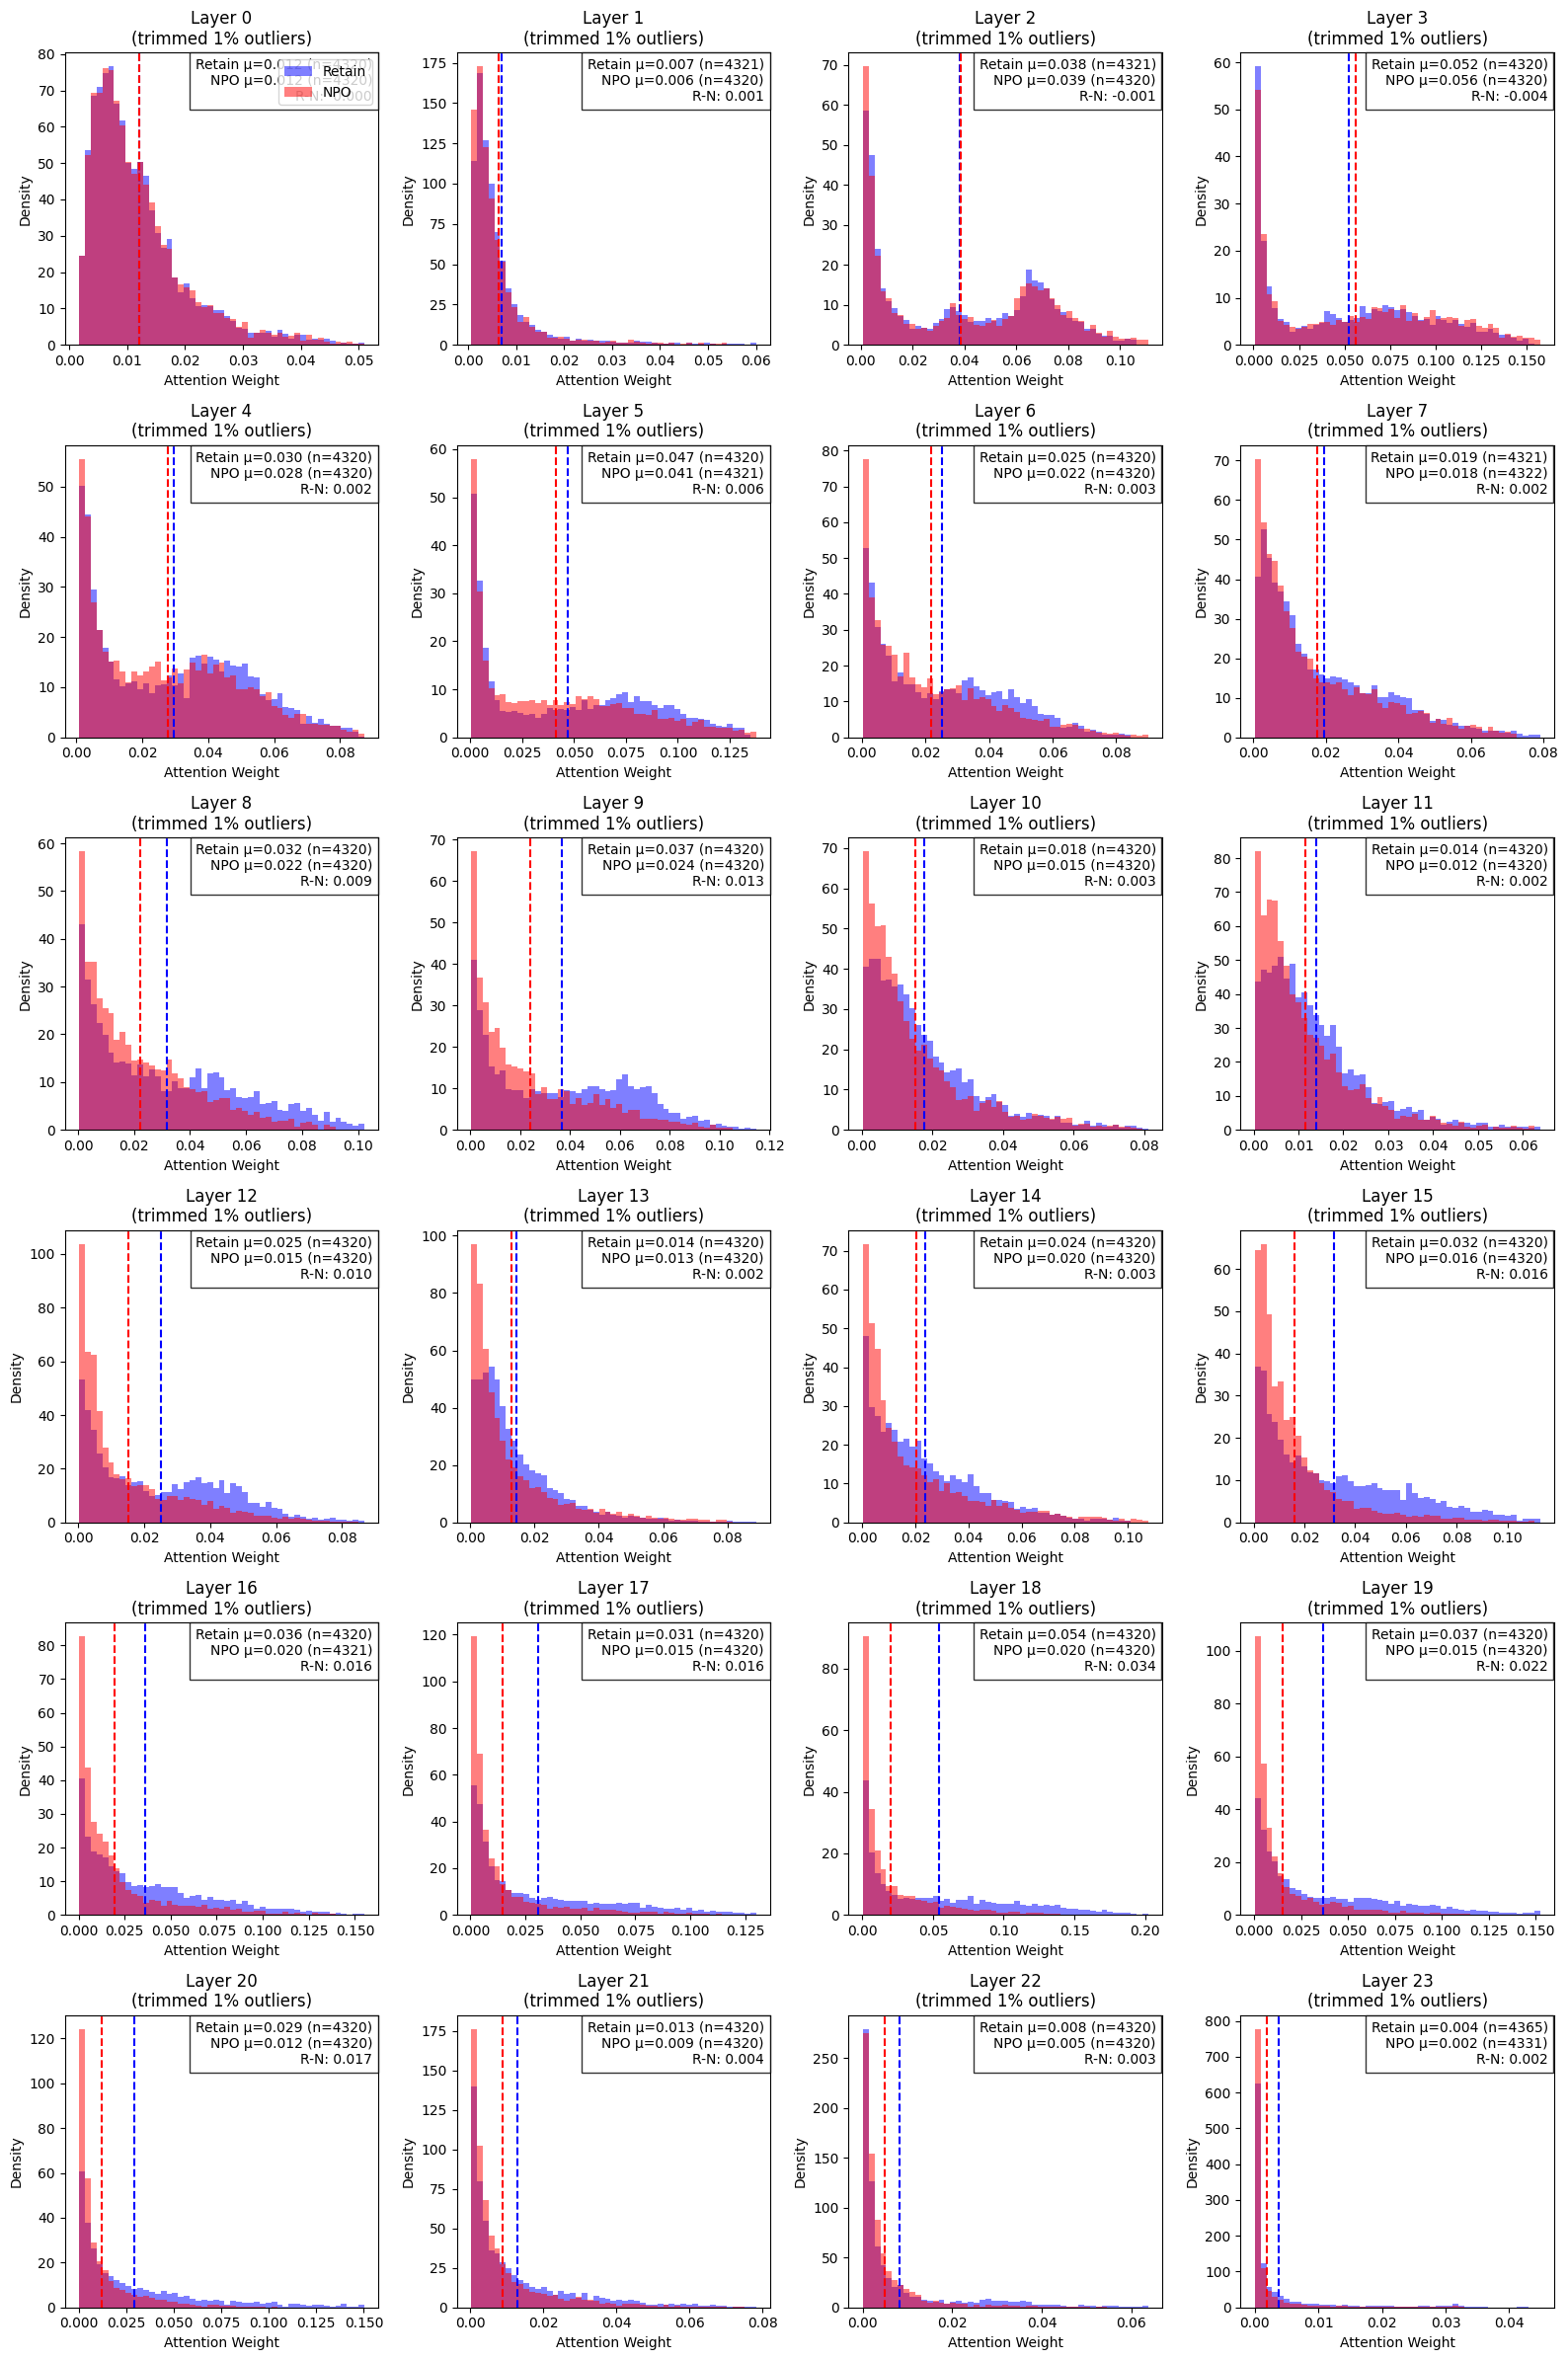

In [ ]:
def get_layer_attention_patterns(model: PreTrainedModel,
                               input_ids: torch.Tensor,
                               attention_mask: torch.Tensor) -> torch.Tensor:
    device = next(model.parameters()).device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True)

    attention_patterns = torch.stack(outputs.attentions, dim=0)
    return attention_patterns

def analyze_attention_for_layer(attention_patterns: torch.Tensor,
                              token_position: int,
                              layer_idx: int) -> torch.Tensor:
    """Get attention patterns for specific layer, averaging over heads."""
    patterns = attention_patterns[layer_idx]  # (batch, num_heads, seq_len, seq_len)
    avg_pattern = patterns.mean(dim=1)[0]  # Average over heads, remove batch dim
    attention_given = avg_pattern[token_position, :]
    return attention_given

def analyze_copy_attention_by_layer(dataset: TofuDataset,
                                  retain_model: PreTrainedModel,
                                  npo_model: PreTrainedModel,
                                  tokenizer: AutoTokenizer,
                                  num_samples: int = 400,
                                  take_from_back: bool = True,
                                  use_ratio: bool = False) -> List[Dict]:
    """Analyze attention patterns for each layer separately."""

    device = next(retain_model.parameters()).device

    test_sample = {k: v.unsqueeze(0).to(device) if isinstance(v, torch.Tensor) else v
                  for k, v in dataset[0].items()}
    test_output = retain_model(test_sample["input_ids"], output_attentions=True)
    num_layers = len(test_output.attentions)
    layer_stats = []

    for layer_idx in range(num_layers):
        stats = {
            "retain": defaultdict(list),
            "npo": defaultdict(list),
            "token_info": [],
            "use_ratio": use_ratio,
            "layer_idx": layer_idx
        }
        layer_stats.append(stats)

    samples = range(len(dataset)-num_samples, len(dataset)) if take_from_back else range(num_samples)

    for idx in tqdm(samples, desc="Analyzing attention patterns"):
        sample = dataset[idx]
        sample = {k: v.unsqueeze(0).to(device) if isinstance(v, torch.Tensor) else v
                 for k, v in sample.items()}

        question_ids, _ = extract_question_tokens(sample, tokenizer.pad_token_id)
        question_length = sample["question_length"].item()

        question_tokens = [(pos, t.item()) for pos, t in enumerate(question_ids[0])
                          if t.item() != tokenizer.pad_token_id]
        question_token_dict = defaultdict(list)
        for pos, token in question_tokens:
            question_token_dict[token].append(pos)

        retain_attention = get_layer_attention_patterns(retain_model, sample["input_ids"], sample["attention_mask"])
        npo_attention = get_layer_attention_patterns(npo_model, sample["input_ids"], sample["attention_mask"])

        seq_len = sample["input_ids"].shape[1]
        full_text = tokenizer.decode(sample["input_ids"][0].cpu())

        for ans_pos in range(question_length, seq_len-1):
            if ans_pos >= seq_len-1:
                continue

            token = sample["input_ids"][0, ans_pos+1].item()
            if token in question_token_dict:
                orig_positions = question_token_dict[token]
                token_str = tokenizer.decode([token])

                for layer_idx in range(num_layers):
                    retain_given = analyze_attention_for_layer(retain_attention, ans_pos, layer_idx)
                    npo_given = analyze_attention_for_layer(npo_attention, ans_pos, layer_idx)

                    retain_to_orig = sum(retain_given[p].item() for p in orig_positions)
                    npo_to_orig = sum(npo_given[p].item() for p in orig_positions)

                    layer_stats[layer_idx]["retain"]["to_orig"].append(retain_to_orig)
                    layer_stats[layer_idx]["npo"]["to_orig"].append(npo_to_orig)

                    token_start_char = len(tokenizer.decode(sample["input_ids"][0, :ans_pos+1].cpu()))
                    token_end_char = len(tokenizer.decode(sample["input_ids"][0, :ans_pos+2].cpu()))

                    text_before = full_text[:token_start_char]
                    text_after = full_text[token_start_char:]
                    word_start = token_start_char - len(text_before.rsplit(None, 1)[-1])
                    word_end = token_start_char + len(text_after.split(None, 1)[0])
                    containing_word = full_text[word_start:word_end]

                    layer_stats[layer_idx]["token_info"].append({
                        "token": token_str,
                        "ans_pos": ans_pos,
                        "orig_pos": orig_positions,
                        "sample_idx": idx,
                        "containing_word": containing_word
                    })

    return layer_stats

def plot_layer_attention_distributions(layer_stats: List[Dict], max_cols: int = 4, trim_outliers_pct: float = 1):
    num_layers = len(layer_stats)
    num_cols = min(max_cols, num_layers)
    num_rows = (num_layers + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols,
                            figsize=(4*num_cols, 4*num_rows))
    if num_layers == 1:
        axes = np.array([[axes]])
    axes = axes.reshape(num_rows, -1)

    for idx, stats in enumerate(layer_stats):
        row = idx // num_cols
        col = idx % num_cols
        ax = axes[row, col]

        retain_attn = np.array(stats["retain"]["to_orig"])
        npo_attn = np.array(stats["npo"]["to_orig"])
        layer_idx = stats["layer_idx"]

        if trim_outliers_pct > 0:
            lower_pct = trim_outliers_pct
            upper_pct = 100 - trim_outliers_pct

            retain_lower, retain_upper = np.percentile(retain_attn, [lower_pct, upper_pct])
            npo_lower, npo_upper = np.percentile(npo_attn, [lower_pct, upper_pct])

            retain_mask = (retain_attn >= retain_lower) & (retain_attn <= retain_upper)
            npo_mask = (npo_attn >= npo_lower) & (npo_attn <= npo_upper)

            retain_attn = retain_attn[retain_mask]
            npo_attn = npo_attn[npo_mask]

        min_val = min(retain_attn.min(), npo_attn.min())
        max_val = max(retain_attn.max(), npo_attn.max())
        bins = np.linspace(min_val, max_val, 50)

        ax.hist(retain_attn, bins=bins, alpha=0.5, label='Retain', color='blue', density=True)
        ax.hist(npo_attn, bins=bins, alpha=0.5, label='NPO', color='red', density=True)
        ax.axvline(np.mean(retain_attn), color='blue', linestyle='--')
        ax.axvline(np.mean(npo_attn), color='red', linestyle='--')

        title = f"Layer {layer_idx}"
        if trim_outliers_pct > 0:
            title += f"\n(trimmed {trim_outliers_pct}% outliers)"
        ax.set_title(title)
        ax.set_xlabel("Attention Weight")
        ax.set_ylabel("Density")

        mean_retain = np.mean(retain_attn)
        mean_npo = np.mean(npo_attn)
        if stats["use_ratio"]:
            mean_diff = mean_retain / mean_npo if mean_npo != 0 else float('inf')
            label = f'R/N: {mean_diff:.2f}'
        else:
            mean_diff = mean_retain - mean_npo
            label = f'R-N: {mean_diff:.3f}'

        retain_count = len(retain_attn)
        npo_count = len(npo_attn)

        ax.text(0.98, 0.98,
            f'Retain μ={mean_retain:.3f} (n={retain_count})\n'
            f'NPO μ={mean_npo:.3f} (n={npo_count})\n'
            f'{label}',
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.8))

        if idx == 0:
            ax.legend(loc='upper right')

    for idx in range(num_layers, num_rows * num_cols):
        row = idx // num_cols
        col = idx % num_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    return fig


layer_stats = analyze_copy_attention_by_layer(
    dataset=dataset,
    retain_model=retain_model,
    npo_model=target_model,
    tokenizer=tokenizer,
    use_ratio=False
)

fig = plot_layer_attention_distributions(layer_stats)
plt.show()

Analyzing attention patterns:   0%|          | 0/400 [00:00<?, ?it/s]

Analyzing attention patterns: 100%|██████████| 400/400 [00:36<00:00, 10.93it/s]


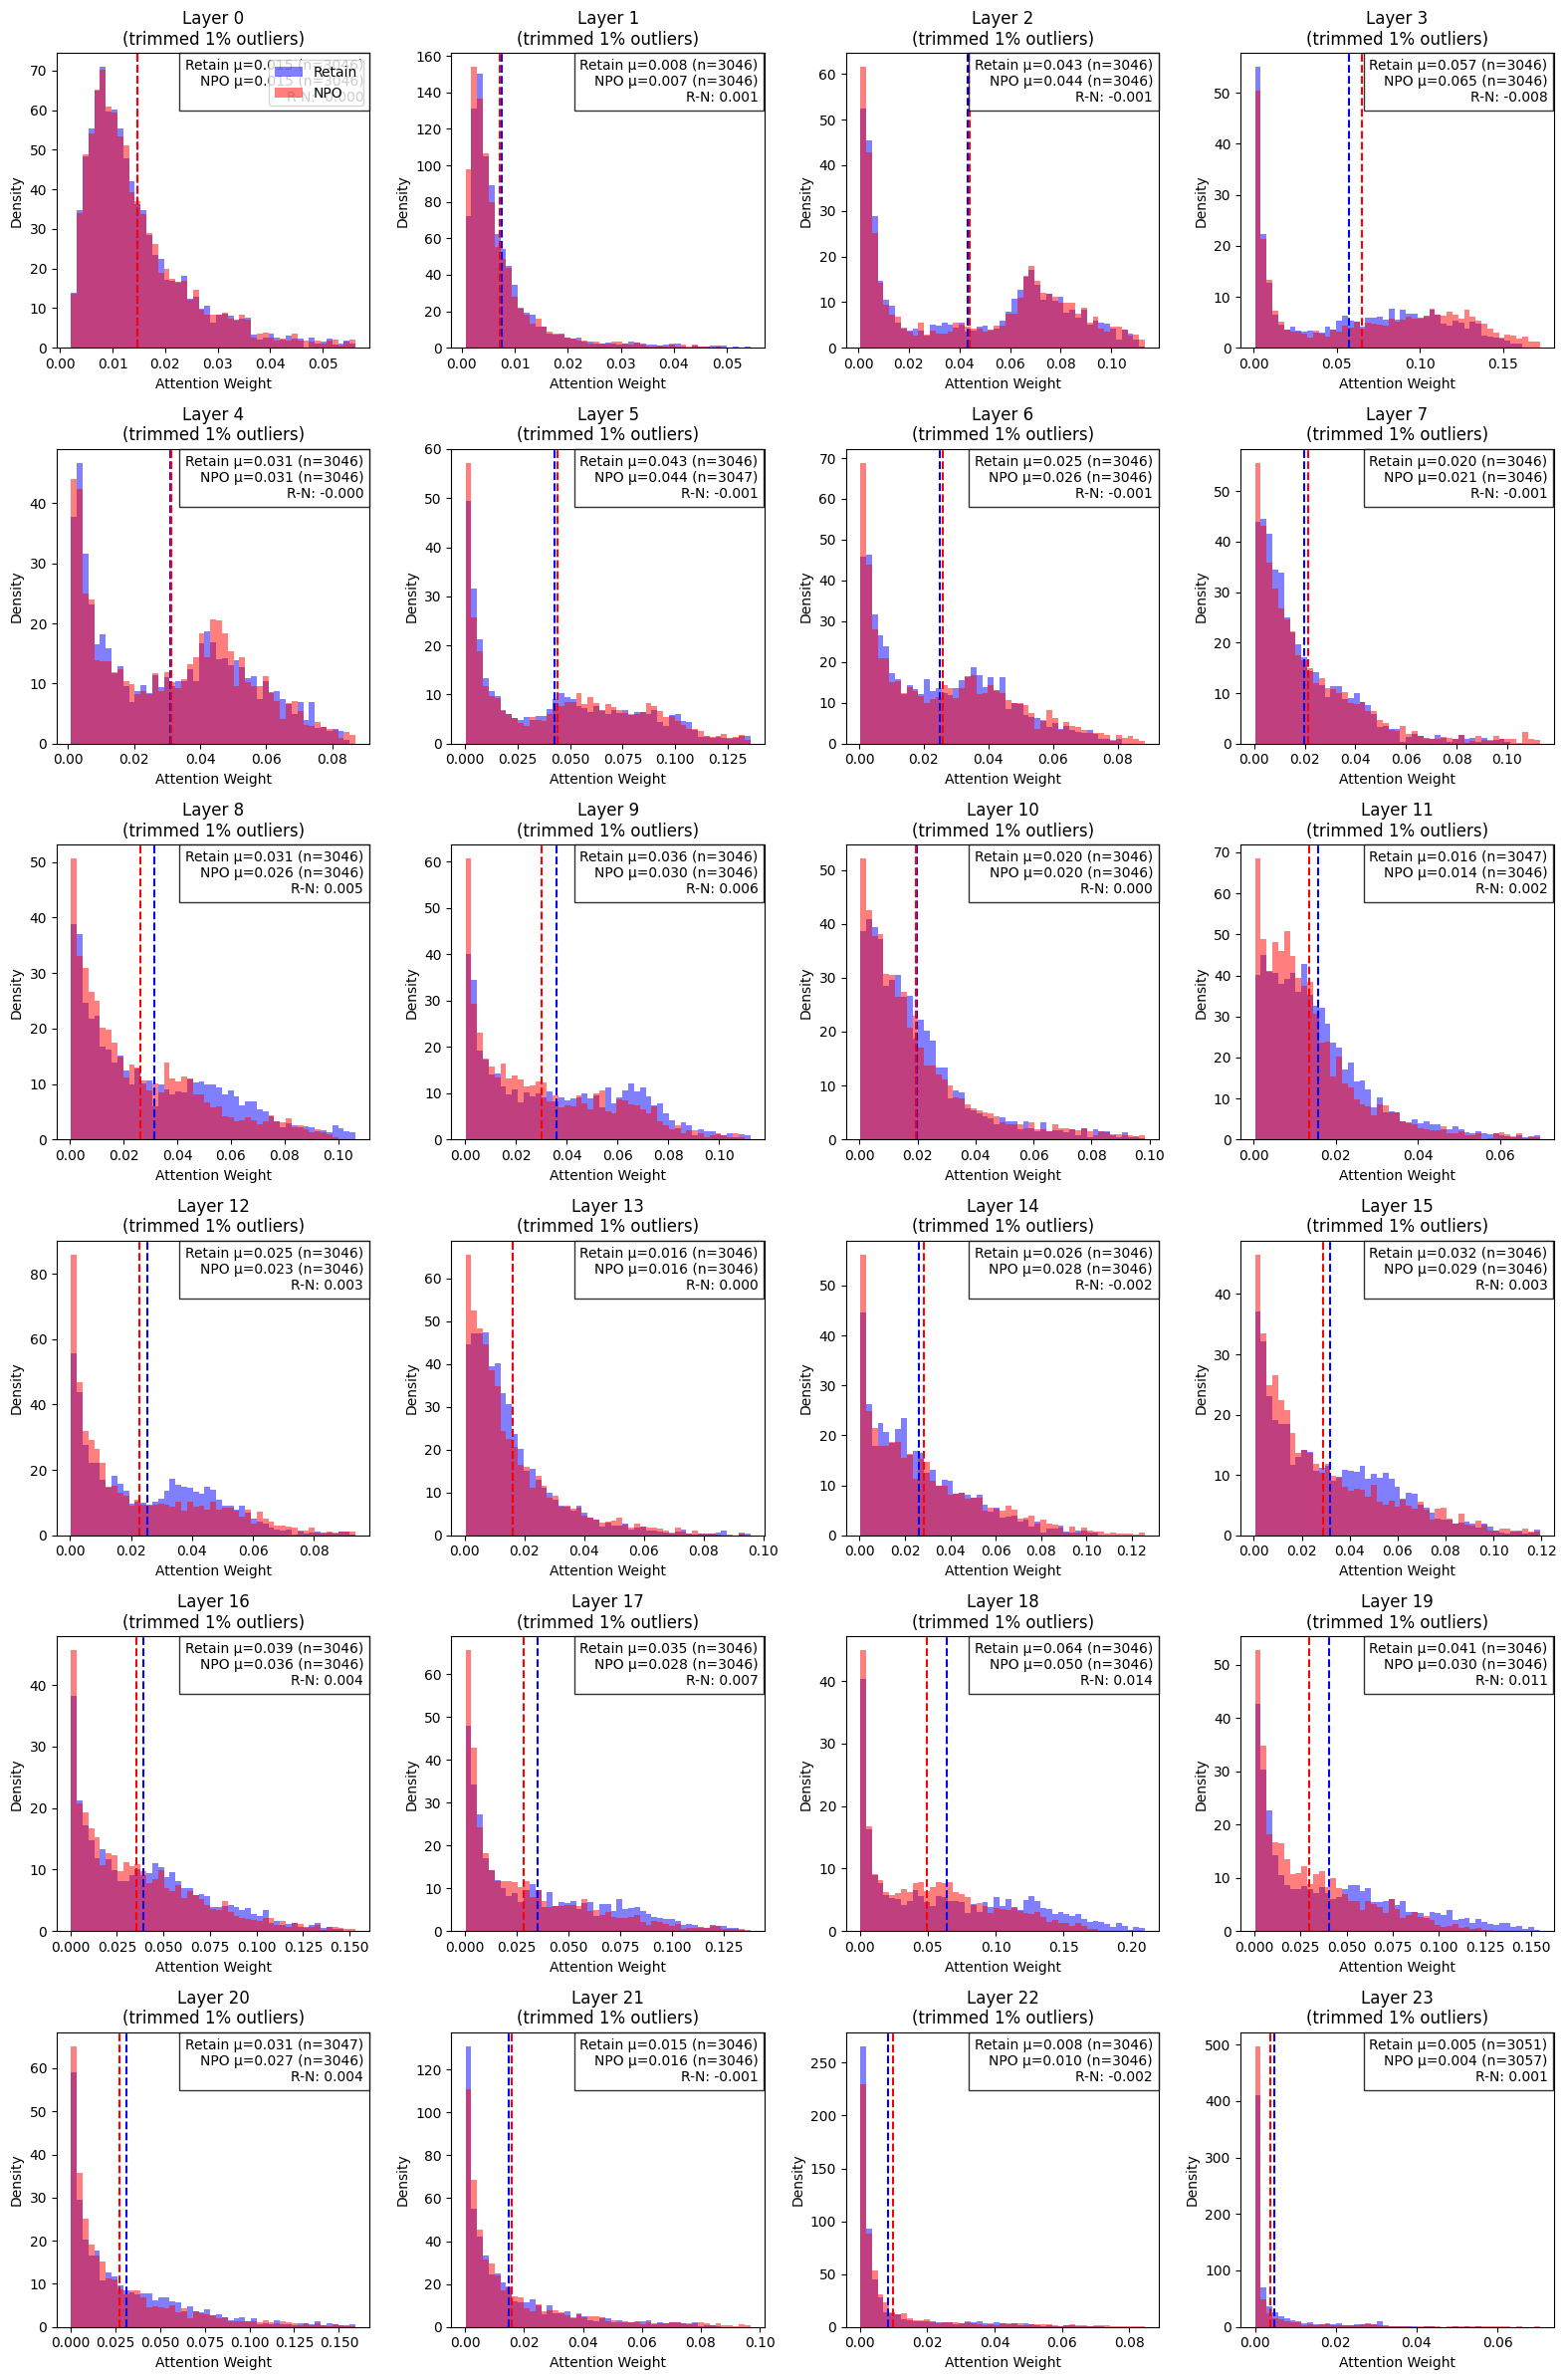

In [11]:
layer_stats = analyze_copy_attention_by_layer(
    dataset=dataset,
    retain_model=retain_model,
    npo_model=target_model,
    tokenizer=tokenizer,
    take_from_back=False
)

fig = plot_layer_attention_distributions(layer_stats)
plt.show()